# Raton deconvolution

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import logging
logger = logging.getLogger()
np.random.seed(40)

In [2]:
from tramp.models import DAGModel, MultiLayerModel
from tramp.base import SISOVariable, SIMOVariable, MILeafVariable
from tramp.likelihoods import GaussianLikelihood
from tramp.channels import DFTChannel, Blur2DChannel, GradientChannel, GaussianChannel
from tramp.priors import GaussBernouilliPrior, BinaryPrior, GaussianPrior
from tramp.algos import (
    ExpectationPropagation, StateEvolution, 
    TrackEvolution, EarlyStopping, JoinCallback, 
    NoisyInit, ConstantInit
)

In [3]:
plt.rc("text", usetex=True)
logger.setLevel(logging.INFO)

In [4]:
def plot_data():
    fig, axs = plt.subplots(1,3,figsize=(12,4))
    axs[0].imshow(x, cmap="gray")
    axs[0].set(title=r"$x$")
    axs[1].imshow(x_blur, cmap="gray")
    axs[1].set(title=r"$g\ast x$")
    axs[2].imshow(y, cmap="gray")
    axs[2].set(title=r"$y$")
    fig.tight_layout()

def plot_prediction(r_pred):
    fig, axs = plt.subplots(1,2,figsize=(8, 4))
    axs[0].imshow(r_pred["x"], cmap="gray")
    axs[0].set(title=r"$x$")
    axs[1].imshow(r_pred["z"], cmap="gray")
    axs[1].set(title=r"$g\ast x$")
    fig.tight_layout()
    
def compare_prediction(r_pred, u1=20):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=False)
    axs[0].plot(x[:,u1], label="true")
    axs[0].plot(r_pred["x"][:,u1], label="pred")
    axs[0].legend()
    axs[0].set(title=r"$x$")
    axs[1].plot(x_blur[:,u1], label="true")
    axs[1].plot(r_pred["z"][:,u1], label="pred")
    axs[1].legend()
    axs[1].set(title=r"$g\ast x$")
    fig.tight_layout()
    
def run_model(model, initializer=None):
    logger.setLevel(logging.INFO)
    callback = EarlyStopping(tol=1e-6, min_variance=1e-15)
    ep = ExpectationPropagation(model)
    ep.iterate(max_iter=30, callback=callback, initializer=initializer)
    r_pred = {x_id: data["r"] for x_id, data in ep.get_variables_data().items()}
    v_pred = {x_id: data["v"] for x_id, data in ep.get_variables_data().items()}
    x_mse = mean_squared_error(x, r_pred["x"])  
    print(f"n_iter={ep.n_iter}")
    print(f"v_pred={v_pred}")
    print(f"x_mse={x_mse}")
    plot_prediction(r_pred)
    compare_prediction(r_pred)

## Image

In [5]:
from scipy.stats import laplace
from scipy.misc import face
raton = face(gray=True).astype(np.float32)

# signal 
s_blur = 10
x = (raton - raton.mean())/raton.std()
print(f"x_mean={x.mean():.2e} x_var={x.var():.2e}")
x_shape = np.shape(x)
# blurring
blur = Blur2DChannel(sigma=[s_blur, s_blur], shape=x_shape)
x_blur = blur.convolve(x)

x_mean=9.72e-08 x_var=1.00e+00


## Raton flou

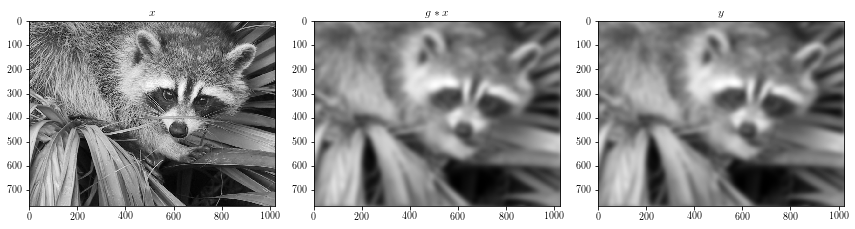

In [6]:
var_noise = 1e-6
y = x_blur + np.sqrt(var_noise)*np.random.standard_normal(x_shape)
plot_data()

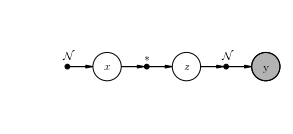

In [7]:
# basic deconv model
prior = GaussianPrior(size=x_shape)
noise = GaussianChannel(var=var_noise)
basic_deconv = MultiLayerModel(
    [prior, blur, noise], ids=["x","z","y"]
).to_observed({"y":y})
basic_deconv.daft()

INFO:root:init message dag with ConstantInit(a=0,b=0)
INFO:root:early stopping: all tolerances are below tol=1.00e-06
INFO:root:terminated after n_iter=2 iterations


n_iter=2
v_pred={'x': 0.98900596522103423, 'z': 1.099403477896573e-08}
x_mse=0.1263520266745777


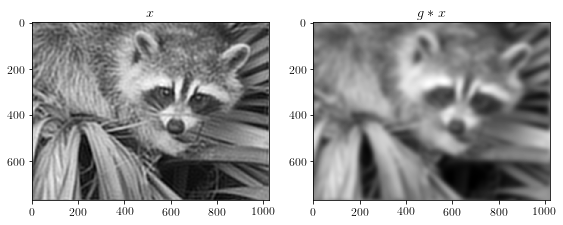

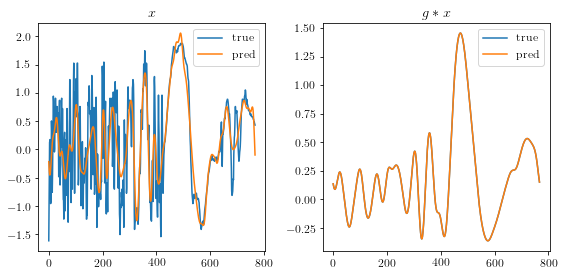

In [8]:
run_model(basic_deconv)

## Raton flou et bruité

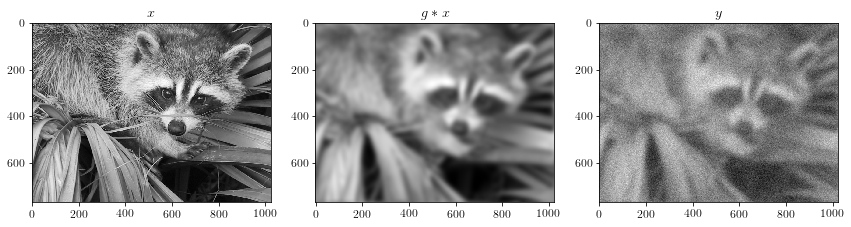

In [9]:
var_noise = 0.1
y = x_blur + np.sqrt(var_noise)*np.random.standard_normal(x_shape)
plot_data()

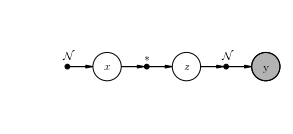

In [10]:
# noisy_deconv model
prior = GaussianPrior(size=x_shape)
noise = GaussianChannel(var=var_noise)
noisy_deconv = MultiLayerModel(
    [prior, blur, noise], ids=["x","z","y"]
).to_observed({"y":y})
noisy_deconv.daft()

INFO:root:init message dag with ConstantInit(a=0,b=0)
INFO:root:early stopping: all tolerances are below tol=1.00e-06
INFO:root:terminated after n_iter=3 iterations


n_iter=3
v_pred={'x': 0.99809181557158733, 'z': 0.00019081844284127465}
x_mse=0.20978505197161496


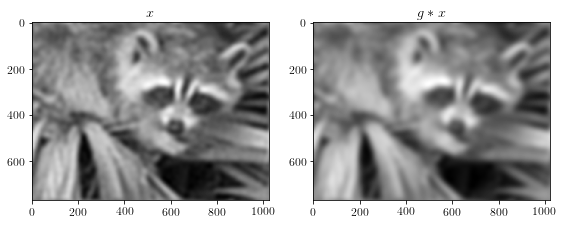

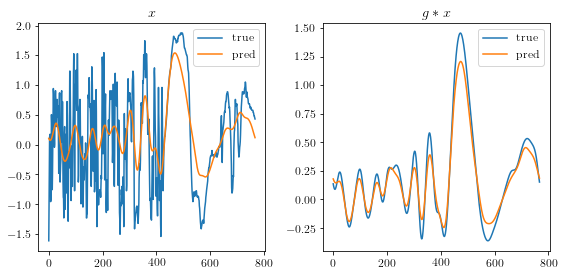

In [11]:
run_model(noisy_deconv)